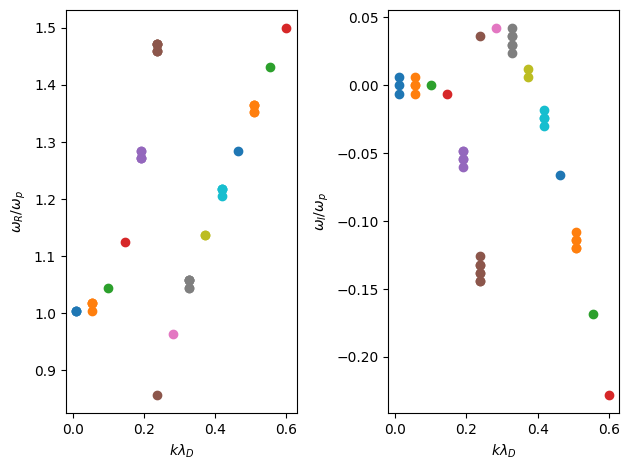

In [3]:
def dfMdv(v):
    return 1./np.sqrt(2*np.pi) * (-v) * np.exp(-0.5*v**2)

def dfBOTdv(v, v0, nb):
    return (1-nb)*dfMdv(v) + 0.5*nb*(dfMdv(v-v0)) + 0.5*nb*(dfMdv(v+v0))

def D_analytic(wr, wi, k0, v0, nb):
    vphi = wr/k0
    eps_v = 1e-3
    v = np.linspace(-12, vphi-eps_v,2048)
    integral = np.trapz(dfBOTdv(v, v0, nb) / (v-(wr+1j*wi)/k0), v)
    v = np.linspace(vphi+eps_v,12, 2048)
    integral += np.trapz(dfBOTdv(v, v0, nb) / (v-(wr+1j*wi)/k0), v)
    d = 1.-1./(k0**2) *integral
    # deforming contour under pole
    if wi == 0:
        d -= 1j*np.pi/k0**2 * dfBOTdv((wr+1j*wi)/k0, v0, nb)
    elif wi<0:
        d -= 2j*np.pi/k0**2 * dfBOTdv((wr+1j*wi)/k0, v0, nb)
    return d

def find_w_roots(k0, v0, nb):
    Wr = np.linspace(0,1.7,128)
    Wi = np.linspace(-0.3,0.3,101)

    D_arr = np.zeros((len(Wi), len(Wr)), dtype = complex)
    for i in range(len(Wi)):
        for j in range(len(Wr)):
            D_arr[i,j] = D_analytic(Wr[j], Wi[i], k0=k0, v0 = v0, nb = nb)
    
    D_analytic_arr = np.abs(D_analytic_arr)
    zeros = np.where(D_analytic_arr<2*D_analytic_arr.min())
    return Wr[zeros[1]][:], Wi[zeros[0]][:]
    
# print(find_w_roots(k0=0.3))

ax1 = plt.subplot(1,2,1)
ax1.set_xlabel(r'$k\lambda_D$')
ax1.set_ylabel(r'$\omega_R/\omega_p$')
ax2 = plt.subplot(1,2,2)
ax2.set_xlabel(r'$k\lambda_D$')
ax2.set_ylabel(r'$\omega_I/\omega_p$')

k0s = np.linspace(0.01,0.6,14)
for k0 in k0s:
    Wrs, Wis = find_w_roots(k0, v0 = 4, nb = 0.1)
    ax1.scatter(k0*np.ones(len(Wrs)), Wrs)
    ax2.scatter(k0*np.ones(len(Wis)), Wis)

plt.tight_layout()



Awesome amazing beautiful. Now let's compare this with the analytical solutions to the dispersion relation that we found in class.

0th order solution is: $\Omega_p^2=\omega^2+\frac{\omega^2}{\lambda_d^2 k^2}$

In [1]:
print("Test to see if github will update changes")

Test to see if github will update changes
